In [39]:
# 1. Thêm các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [29]:
# Load dữ liệu cifar10
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [30]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# data normalization để áp dụng Softmax function, đầu ra là xác xuất
x_train /= 255
x_test /= 255
num_classes = 10 
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [31]:
from os import path

# build model
model = Sequential()

save_model_path = "/content/drive/MyDrive/save-model/cifar10.h5"
if (path.exists(save_model_path)):   
  model  =  models.load_model(save_model_path)
else:
  # activation Relu là f(s) = max(0, s) đưa các gtri âm về 0,
  # đảm bảo cho các giá trị là không tuyến tính
  # dropout để tránh overfit
  # CONV => RELU => CONV => RELU => POOL => DROPOUT
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # CONV => RELU => CONV => RELU => POOL => DROPOUT
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # chuyển từ tensor sang vector ->thêm fully connected vs 512 nodes và dùng hàm relu
  # FLATTERN => DENSE => RELU => DROPOUT
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  # a softmax classifier -> dạng xác xuất
  model.add(Dense(10))
  model.add(Activation('softmax'))
  model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_28 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_29 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 15, 15, 64)       

In [32]:
checkpoint = ModelCheckpoint(save_model_path,  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor
callbacks_list = [checkpoint]

In [33]:
# initiate RMSprop optimizer
from tensorflow.keras import optimizers
opt = optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [34]:
# Thực hiện train model với data
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = False
history = None
if not data_augmentation:
  print("Not using data augmentation")
  history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose = 1, 
              callbacks = callbacks_list,
              validation_data=(x_test, y_test))
else:
  print("Using realtime data augmentation")
  datagen = ImageDataGenerator(
      featurewise_center=False,  # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      zca_epsilon=1e-06,  # epsilon for ZCA whitening
      rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
      # randomly shift images horizontally (fraction of total width)
      width_shift_range=0.1,
      # randomly shift images vertically (fraction of total height)
      height_shift_range=0.1,
      shear_range=0.,  # set range for random shear
      zoom_range=0., # set range for random zoom
      channel_shift_range=0.,  # set range for random channel shifts
      # set mode for filling points outside the input boundaries
      fill_mode='nearest',
      cval=0.,  # value used for fill_mode = "constant"
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False,  # randomly flip images
      # set rescaling factor (applied before any other transformation)
      rescale=None,
      # set function that will be applied on each input
      preprocessing_function=None,
      # image data format, either "channels_first" or "channels_last"
      data_format=None,
      # fraction of images reserved for validation (strictly between 0 and 1)
      validation_split=0.0)
  
  datagen.fit(x_train)
  history = model.fit_generator(datagen.flow(x_train, y_train),
                                epochs=epochs,
                                validation_data=(x_test, y_test),
                                workers= 4)

Not using data augmentation
Epoch 1/100
1563/1563 [==============================] - 28s 17ms/step - loss: 1.7643 - accuracy: 0.3581 - val_loss: 1.5135 - val_accuracy: 0.4490
Epoch 2/100
1563/1563 [==============================] - 26s 17ms/step - loss: 1.4558 - accuracy: 0.4743 - val_loss: 1.3199 - val_accuracy: 0.5181
Epoch 3/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3104 - accuracy: 0.5345 - val_loss: 1.2268 - val_accuracy: 0.5602
Epoch 4/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2023 - accuracy: 0.5734 - val_loss: 1.1039 - val_accuracy: 0.6118
Epoch 5/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1189 - accuracy: 0.6086 - val_loss: 1.0347 - val_accuracy: 0.6375
Epoch 6/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.0522 - accuracy: 0.6295 - val_loss: 0.9830 - val_accuracy: 0.6529
Epoch 7/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9948 - ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


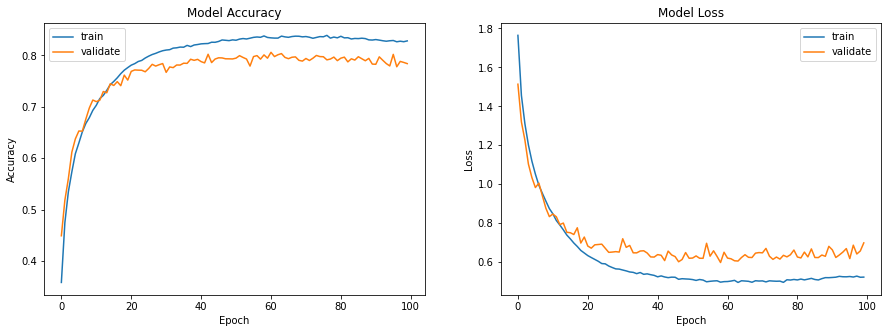

In [36]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper right')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [37]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

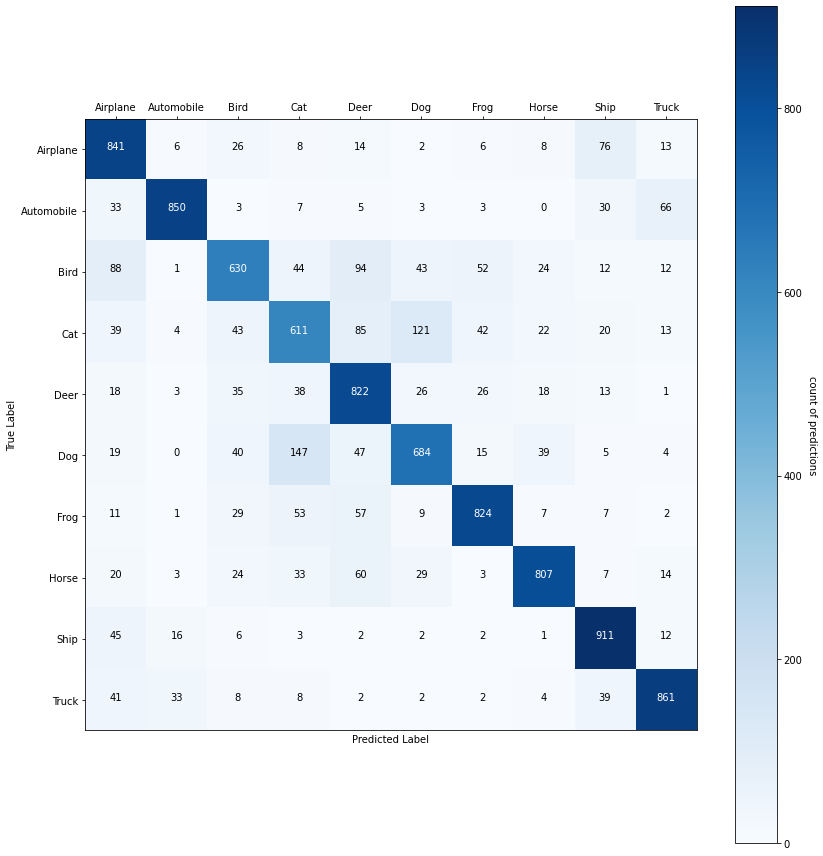

In [40]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

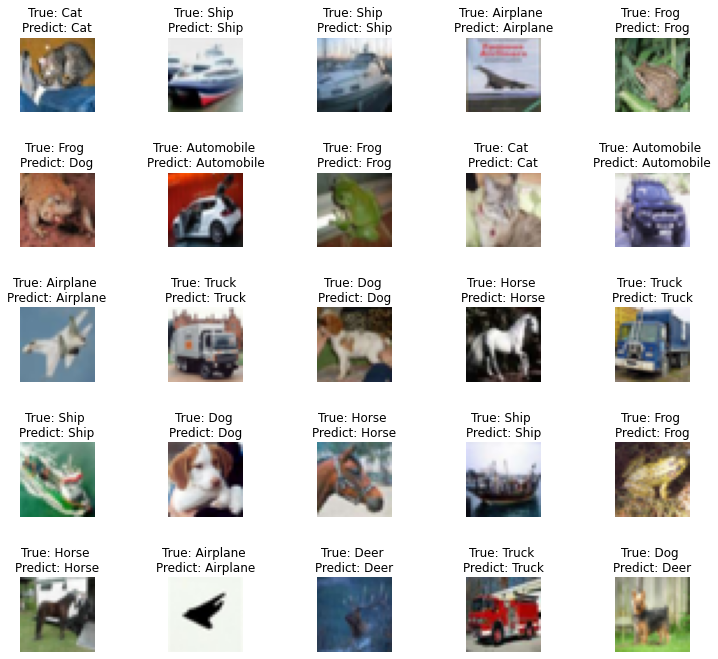

In [41]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)